In [112]:
import parser
import json
import urllib
import pandas as pd
import imp
import numpy as np
import seaborn as sns
import math
from PIL import Image
import matplotlib.pyplot as plt
import imdb_movie_content
%matplotlib inline
imp.reload(parser)
imp.reload(imdb_movie_content)

<module 'imdb_movie_content' from '/Users/alexandreattia/Desktop/Work/Practice/HackerRankChallenge/KaggleMovieRating/imdb_movie_content.py'>

In [113]:
df = parser.create_dataframe("movie_contents2.json", "movie_budget.json")
df.set_index('movie_title', inplace=True, drop=False)
awards_columns = [col for col in df.columns if 'nominated' in col or 'won' in col]
df_awards = df[awards_columns]
awards_per_movie = (len(awards_columns) - df_awards.isnull().sum(axis=1)).to_dict()
df['nb_awards'] = df['movie_title'].map(awards_per_movie)

## Awards and Gross

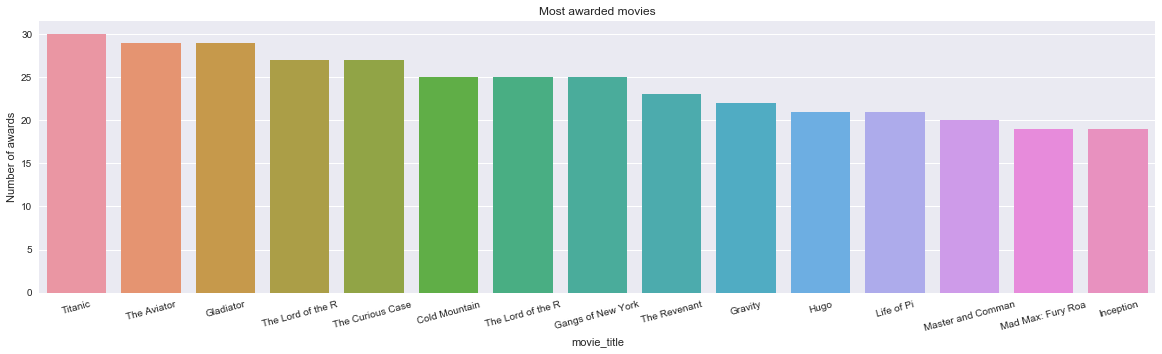

In [43]:
d = df['nb_awards'].sort_values(ascending=False)[:15]
plt.figure(figsize=(20,5))
plot = sns.barplot(x=d.index, y=d)
_ = plot.set_xticklabels([elem[:17] for elem in d.index], rotation=15)
_ = plot.set_title('Most awarded movies')
_ = plot.set_ylabel('Number of awards')

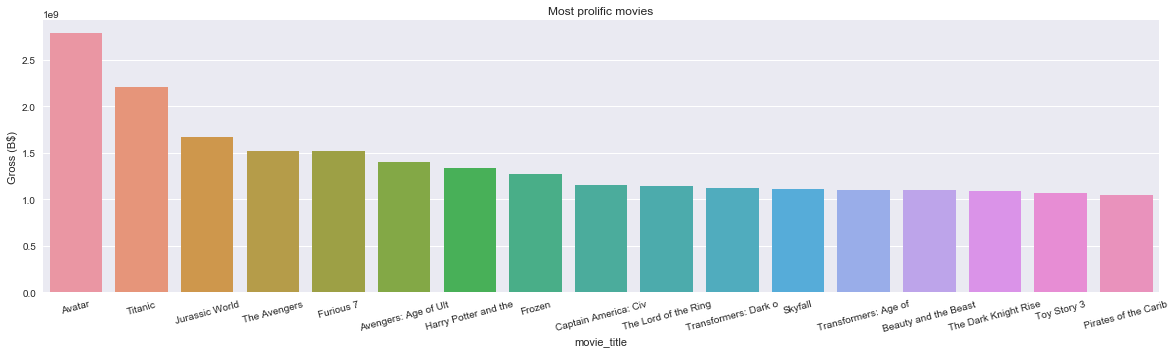

In [207]:
d = df.worldwide_gross.sort_values(ascending=False)[:17]
plt.figure(figsize=(20,5))
plot = sns.barplot(x=d.index, y=d)
_ = plot.set_xticklabels([elem[:20] for elem in d.index], rotation=15)
_ = plot.set_title('Most prolific movies')
_ = plot.set_ylabel('Gross (B$)')

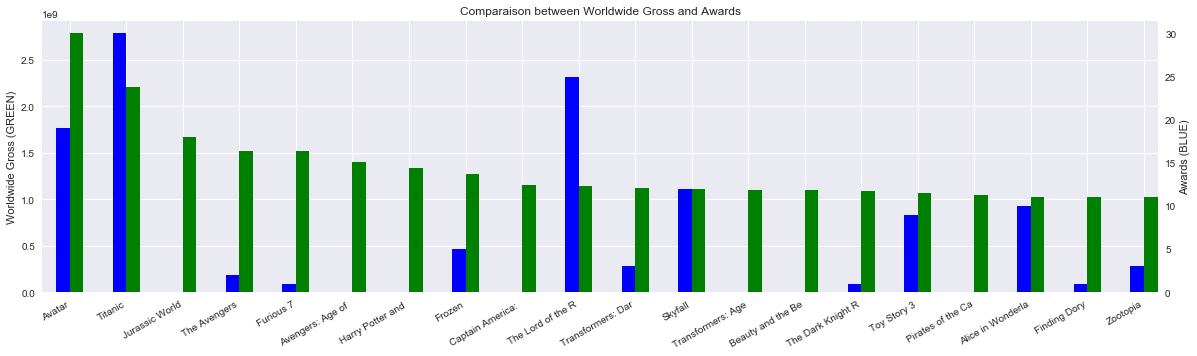

In [222]:
sns.set()

d = df.worldwide_gross.sort_values(ascending=False)[:20]
e = len(award_columns) - df_awards[df_awards.index.isin(d.index)].isnull().sum(axis=1).reindex(d.index)
margin = 0.05
width = 4*(1.-2.*margin)/15
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
ax2 = ax.twinx()
d.plot(kind='bar', color='green', ax=ax, width=width, position=0)
e.plot(kind='bar', color='blue', ax=ax2, width=width, position=1)
ax.set_ylabel('Worldwide Gross (GREEN)')
ax2.set_ylabel('Awards (BLUE)')
ax.set_xlabel('')
ax.set_title('Comparaison between Worldwide Gross and Awards')
_ = ax.set_xticklabels([elem[:17] for elem in d.index], rotation = 30, ha='right')
ax2.grid(False)

## Facebook likes

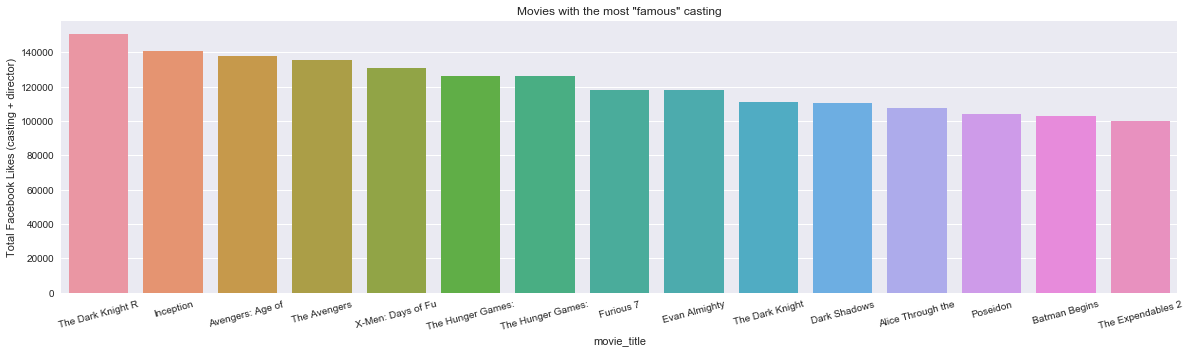

In [123]:
d = df['total_cast_fb_likes'].sort_values(ascending=False)[:15]
e = df[df.index.isin(d.index)].num_facebook_like
plt.figure(figsize=(20,5))
plot = sns.barplot(x=d.index, y=d)
_ = plot.set_xticklabels([elem[:17] for elem in d.index], rotation=15)
_ = plot.set_title('Movies with the most "famous" casting')
_ = plot.set_ylabel('Total Facebook Likes (casting + director)')

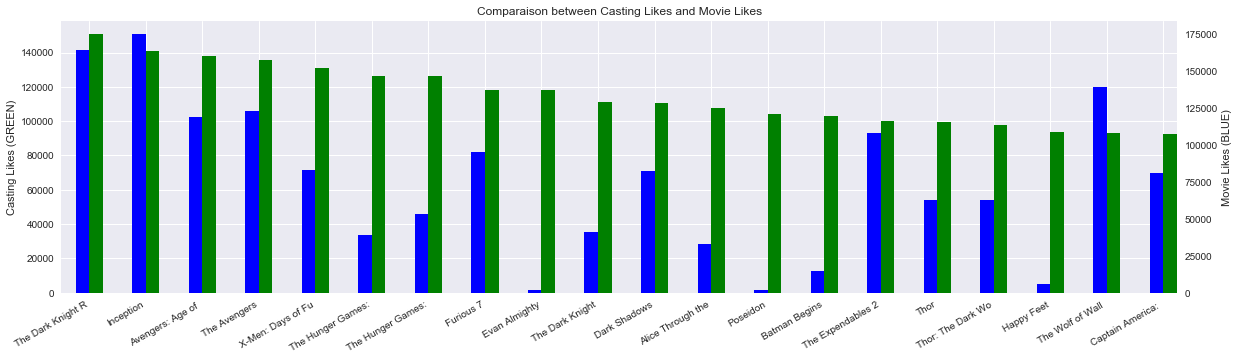

In [236]:
sns.set()

d = df['total_cast_fb_likes'].sort_values(ascending=False)[:20]
e = df[df.index.isin(d.index)].num_facebook_like.reindex(d.index)
margin = 0.05
width = 4*(1.-2.*margin)/15
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
ax2 = ax.twinx()
d.plot(kind='bar', color='green', ax=ax, width=width, position=0)
e.plot(kind='bar', color='blue', ax=ax2, width=width, position=1)
ax.set_ylabel('Casting Likes (GREEN)')
ax2.set_ylabel('Movie Likes (BLUE)')
ax.set_xlabel('')
ax.set_title('Comparaison between Casting Likes and Movie Likes')
_ = ax.set_xticklabels([elem[:17] for elem in d.index], rotation = 30, ha='right')
ax2.grid(False)

## Best Actors

### Actor in movie

In [134]:
all_actors = [actor for actor in list(set(list(df.actor_1_name) + list(df.actor_2_name) + list(df.actor_3_name))) if pd.notnull(actor)]
imdb_score_per_actor = {}
for actor in all_actors:
    imdb_score_per_actor[actor] = df[(df.actor_1_name == actor) | (df.actor_2_name == actor) | (df.actor_3_name == actor)].idmb_score.mean()

In [190]:
millnames = ['',' K',' M',' B']
def millify(n):
    if pd.notnull(n):
        n = float(n)
        millidx = max(0,min(len(millnames)-1,
                            int(math.floor(0 if n == 0 else math.log10(abs(n))/3))))
        return '{:.1f}{}'.format(n / 10**(3 * millidx), millnames[millidx])
    else:
        return n

In [176]:
gross_per_actor = {}
for actor in all_actors:
    gross_per_actor[actor] = df[(df.actor_1_name == actor) | (df.actor_2_name == actor) | (df.actor_3_name == actor)].worldwide_gross.mean()

In [183]:
top_k = 10
best = [elem[0]+ ', %s (%s movie.s)' % (round(elem[1], 1),len(df[(df.actor_1_name == elem[0]) 
                                           | (df.actor_2_name == elem[0]) 
                                           | (df.actor_3_name == elem[0])])) 
        for elem in sorted(imdb_score_per_actor.items(), key=lambda x:x[1], reverse=True)][:top_k]

mini_movie = 3
best_mini = [elem[0]+ ', %s (%s movie.s)' % (round(elem[1], 1),len(df[(df.actor_1_name == elem[0]) 
                                           | (df.actor_2_name == elem[0]) 
                                           | (df.actor_3_name == elem[0])]))
        for elem in sorted(imdb_score_per_actor.items(), key=lambda x:x[1], reverse=True) if len(df[(df.actor_1_name == elem[0]) 
                                                                                                   | (df.actor_2_name == elem[0]) 
                                                                                                   | (df.actor_3_name == elem[0])]) >= mini_movie][:top_k]

best_gross_mini = [elem[0]+ ', %s$ (%s movie.s)' % (millify(elem[1]), len(df[(df.actor_1_name == elem[0]) 
                                           | (df.actor_2_name == elem[0]) 
                                           | (df.actor_3_name == elem[0])]))
        for elem in sorted(gross_per_actor.items(), key=lambda x:x[1], reverse=True) if len(df[(df.actor_1_name == elem[0]) 
                                                                                                   | (df.actor_2_name == elem[0]) 
                                                                                                   | (df.actor_3_name == elem[0])]) >= mini_movie][:top_k]
print('The {} best actors (in terms of IMDB score when they played if the movie) are : \n{}'.format(top_k,
       '\n'.join(best)))

print('\nThe {} best actors are with minimum {} movies : \n{}'.format(top_k, mini_movie,
       '\n'.join(best_mini)))

print('\nThe {} most prolific actors are with minimum {} movies : \n{}'.format(top_k, mini_movie,
       '\n'.join(best_gross_mini)))

The 10 best actors (in terms of IMDB score when they played if the movie) are : 
Mackenzie Foy, 8.6 (1 movie.s)
Joaquin Phoenix, 8.5 (1 movie.s)
Robert Patrick, 8.5 (1 movie.s)
Tommy Flanagan, 8.5 (1 movie.s)
Edward Furlong, 8.5 (1 movie.s)
Kathy Najimy, 8.4 (1 movie.s)
Stephen Merchant, 8.4 (1 movie.s)
Patrick Stewart, 8.4 (1 movie.s)
Pete Docter, 8.4 (1 movie.s)
Matthew McConaughey, 8.4 (2 movie.s)

The 10 best actors are with minimum 3 movies : 
Tom Hardy, 8.4 (4 movie.s)
Leonardo DiCaprio, 8.1 (8 movie.s)
Cate Blanchett, 8.1 (7 movie.s)
Tom Hanks, 7.9 (3 movie.s)
Russell Crowe, 7.8 (3 movie.s)
Orlando Bloom, 7.8 (7 movie.s)
Martin Freeman, 7.7 (3 movie.s)
Zoe Saldana, 7.7 (4 movie.s)
Christian Bale, 7.7 (5 movie.s)
Matt Damon, 7.6 (6 movie.s)

The 10 most prolific actors are with minimum 3 movies : 
Robert Pattinson, 896.9 M$ (3 movie.s)
Orlando Bloom, 682.8 M$ (7 movie.s)
Alan Tudyk, 573.3 M$ (6 movie.s)
Philip Seymour Hoffman, 495.1 M$ (5 movie.s)
Dustin Hoffman, 487.1 M$ (3 movi

### First star in movie

In [227]:
big_star = df.groupby(['actor_1_name'])['idmb_score', 'worldwide_gross'].mean().sort_values(['idmb_score', 'worldwide_gross'], ascending=False)
big_star['nb_movies'] = big_star.index
big_star['nb_movies'] = big_star['nb_movies'].map(df.groupby(['actor_1_name'])['movie_title'].count().to_dict())
big_star['worldwide_gross'] = big_star['worldwide_gross'].apply(millify)
top_k = 7
print('The {} best actors as most famous actor are :'.format(top_k))
big_star[big_star.nb_movies >= 3].head(top_k)

The 7 best actors as most famous actor are :


,idmb_score,worldwide_gross,nb_movies
actor_1_name,,,
Leonardo DiCaprio,8.125000,398.5 M,8
Tom Hanks,7.900000,570.6 M,3
Christopher Lee,7.866667,729.7 M,3
Richard Armitage,7.733333,977.5 M,3
Matt Damon,7.625000,420.2 M,4
Robert Downey Jr.,7.500000,786.6 M,4
Christian Bale,7.475000,499.0 M,4


In [229]:
big_star = df.groupby(['actor_1_name'])['idmb_score', 'worldwide_gross'].mean().sort_values(['worldwide_gross', 'idmb_score'], ascending=False)
big_star['nb_movies'] = big_star.index
big_star['nb_movies'] = big_star['nb_movies'].map(df.groupby(['actor_1_name'])['movie_title'].count().to_dict())
big_star['worldwide_gross'] = big_star['worldwide_gross'].apply(millify)
top_k = 7
print('The {} most prolific actors as most famous actor are :'.format(top_k))
big_star[big_star.nb_movies >= 3].head(top_k)

The 7 most prolific actors as most famous actor are :


,idmb_score,worldwide_gross,nb_movies
actor_1_name,,,
Richard Armitage,7.733333,977.5 M,3
Robert Pattinson,6.233333,896.9 M,3
J.K. Simmons,7.100000,807.0 M,6
Robert Downey Jr.,7.500000,786.6 M,4
Chris Hemsworth,7.083333,751.6 M,6
Christopher Lee,7.866667,729.7 M,3
Jennifer Lawrence,7.285714,708.4 M,7


## IMDB rating and other variables

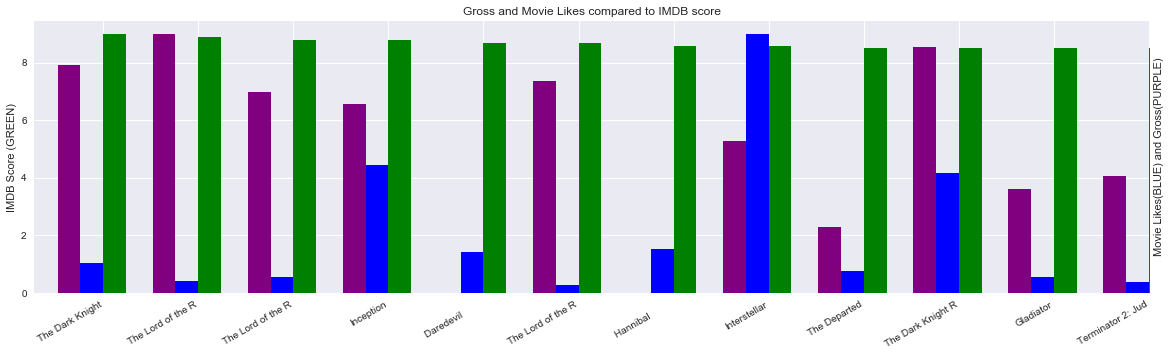

In [249]:
d = df['idmb_score'].apply(float).sort_values(ascending=False)[:12]
e = df[df.index.isin(d.index)].num_facebook_like.reindex(d.index)
f = df[df.index.isin(d.index)].worldwide_gross.reindex(d.index)
margin = 0.05
width = 4*(1.-2.*margin)/15
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
ax2 = ax.twinx()
ax3= ax2.twinx()
d.plot(kind='bar', color='green', ax=ax, width=width, position=0)
e.plot(kind='bar', color='blue', ax=ax2, width=width, position=1)
f.plot(kind='bar', color='purple', ax=ax3, width=width, position=2)
ax.set_ylabel('IMDB Score (GREEN)')
ax2.set_ylabel('Movie Likes(BLUE) and Gross(PURPLE)')
ax3.set_yticklabels('')
ax2.set_yticklabels('')
ax.set_xlabel('')
_ = ax.set_xticklabels([elem[:17] for elem in d.index], rotation = 30, ha='right')
ax3.grid(False)
ax2.grid(False)
ax.set_title('Gross and Movie Likes compared to IMDB score')

,nb_awards,domestic_gross,worldwide_gross,total_cast_fb_likes,director_fb_links,production_budget,num_critic_for_reviews,idmb_score,actor_1_fb_likes,actor_2_fb_likes,actor_3_fb_likes
nb_awards,1.000000,0.288704,0.287722,0.116932,0.426060,0.065141,0.253846,0.471797,0.046625,0.100248,0.069805
domestic_gross,0.288704,1.000000,0.917700,0.305285,0.166042,0.511724,0.485672,0.456245,0.081272,0.281862,0.294937
worldwide_gross,0.287722,0.917700,1.000000,0.287975,0.148861,0.602844,0.497498,0.429627,0.041049,0.274243,0.314580
total_cast_fb_likes,0.116932,0.305285,0.287975,1.000000,0.401001,0.266568,0.397123,0.223107,0.759290,0.836350,0.837937
director_fb_links,0.426060,0.166042,0.148861,0.401001,1.000000,0.088485,0.340943,0.341471,0.149429,0.239375,0.286238
production_budget,0.065141,0.511724,0.602844,0.266568,0.088485,1.000000,0.524155,0.163527,0.127259,0.214428,0.241036
num_critic_for_reviews,0.253846,0.485672,0.497498,0.397123,0.340943,0.524155,1.000000,0.425479,0.157902,0.385205,0.375501
idmb_score,0.471797,0.456245,0.429627,0.223107,0.341471,0.163527,0.425479,1.000000,0.075944,0.160326,0.198069
actor_1_fb_likes,0.046625,0.081272,0.041049,0.759290,0.149429,0.127259,0.157902,0.075944,1.000000,0.512519,0.414626
actor_2_fb_likes,0.100248,0.281862,0.274243,0.836350,0.239375,0.214428,0.385205,0.160326,0.512519,1.000000,0.832349


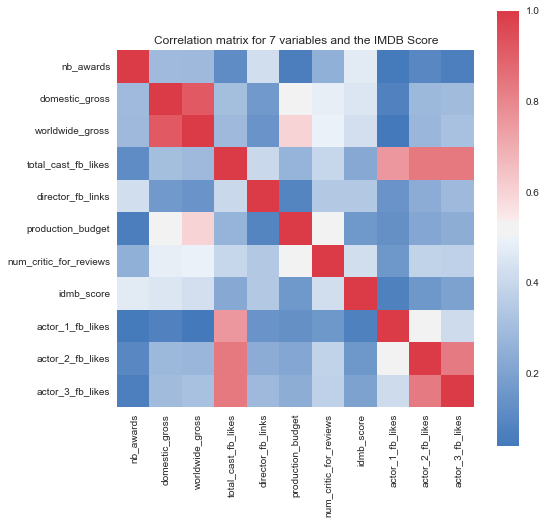

In [233]:
# Correlation Matrix

corr = df[['nb_awards', 'domestic_gross','worldwide_gross', 
    'total_cast_fb_likes','director_fb_links', 'production_budget',
    'num_critic_for_reviews', 'idmb_score', 'actor_1_fb_likes', 'actor_2_fb_likes', 'actor_3_fb_likes']].corr()

plt.figure(figsize=(8,8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(250, 10, as_cmap=True),
            square=True)
plt.title('Correlation matrix for 7 variables and the IMDB Score')
corr